In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_under.csv')
data.head()

,userId,wine,rate
0,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1
1,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1
2,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1
3,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Terrano,1
4,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [4]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2723
RMSE: 1.0725
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2527
RMSE: 1.0074
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2544
RMSE: 1.0803
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2239
RMSE: 1.1457
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2694
RMSE: 1.0895
###############################################
The Results are: 

Average RMSE on Training Set: 0.2545390222015392
Average RMSE on Test Set: 1.0790886986867343
RMSE: 1.0858
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0858478467775439
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0858
MAE:  0.9056
MSE: 1.1791
Precision: 0.61
Recall: 0.71
the acc is 30.71


/tmp/ipykernel_18107/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [5]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3038
RMSE: 1.0281
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2782
RMSE: 1.1549
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2887
RMSE: 1.1361
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2980
RMSE: 1.1295
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2520
RMSE: 1.0313
###############################################
The Results are: 

Average RMSE on Training Set: 0.2841304226208744
Average RMSE on Test Set: 1.0959654096039542
RMSE: 1.1124
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1124049285819235
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1124
MAE:  0.8988
MSE: 1.2374
Precision: 0.66
Recall: 0.73
the acc is 33.07


/tmp/ipykernel_18107/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [6]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1655
RMSE: 1.0844
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1850
RMSE: 1.0247
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1783
RMSE: 1.0853
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1868
RMSE: 1.0394
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1819
RMSE: 1.0485
###############################################
The Results are: 

Average RMSE on Training Set: 0.17948279265805872
Average RMSE on Test Set: 1.0564604811560507
RMSE: 1.1429
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.142947407759277
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1429
MAE:  0.9486
MSE: 1.3063
Precision: 0.66
Recall: 0.71
the acc is 29.92


/tmp/ipykernel_18107/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [7]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2552
RMSE: 1.0701
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2555
RMSE: 1.0910
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2917
RMSE: 1.0937
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2476
RMSE: 1.2136
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2350
RMSE: 1.1480
###############################################
The Results are: 

Average RMSE on Training Set: 0.25697293058539045
Average RMSE on Test Set: 1.1232638194690083
RMSE: 1.1582
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.158214069912621
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1582
MAE:  0.9661
MSE: 1.3415
Precision: 0.60
Recall: 0.66
the acc is 33.07


/tmp/ipykernel_18107/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [8]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1627
RMSE: 1.0139
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2048
RMSE: 1.0697
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1362
RMSE: 1.2484
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1523
RMSE: 1.1709
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1830
RMSE: 1.0849
###############################################
The Results are: 

Average RMSE on Training Set: 0.16779048712571848
Average RMSE on Test Set: 1.1175676554581329
RMSE: 1.0127
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0127171473324608
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0127
MAE:  0.8659
MSE: 1.0256
Precision: 0.66
Recall: 0.69
the acc is 28.35


/tmp/ipykernel_18107/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1457
RMSE: 1.0236
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1443
RMSE: 1.0558
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1531
RMSE: 1.0939
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1473
RMSE: 1.1917
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1246
RMSE: 0.9783
###############################################
The Results are: 

Average RMSE on Training Set: 0.1429865120260431
Average RMSE on Test Set: 1.068665758167074
RMSE: 1.1634
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1633860961483096
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1634
MAE:  0.9331
MSE: 1.3535
Precision: 0.61
Recall: 0.66
the acc is 33.86


/tmp/ipykernel_18107/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1095
RMSE: 1.0688
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0975
RMSE: 1.1444
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1813
RMSE: 1.1622
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1575
RMSE: 0.9369
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1873
RMSE: 1.1253
###############################################
The Results are: 

Average RMSE on Training Set: 0.146633823110283
Average RMSE on Test Set: 1.087510795914325
RMSE: 1.0942
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0941577878248032
Computing the pearson_baseline similarity matrix...

/tmp/ipykernel_18107/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0644
RMSE: 1.1422
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1238
RMSE: 1.1510
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1170
RMSE: 1.0035
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0955
RMSE: 1.0091
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1236
RMSE: 1.0552
###############################################
The Results are: 

Average RMSE on Training Set: 0.10485623152623873
Average RMSE on Test Set: 1.0722087271338907
RMSE: 1.0860
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0859549929252081
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18107/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [12]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2760
RMSE: 1.0287
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2359
RMSE: 1.0234
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2387
RMSE: 1.0860
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2784
RMSE: 1.0768
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2540
RMSE: 1.1029
###############################################
The Results are: 

Average RMSE on Training Set: 0.25659775857660644
Average RMSE on Test Set: 1.0635734457083699
RMSE: 1.1417
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1417422322278237
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1417
MAE:  0.9538
MSE: 1.3036
Precision: 0.61
Recall: 0.64
the acc is 27.56


/tmp/ipykernel_18107/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [13]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2218
RMSE: 1.0867
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1995
RMSE: 1.0659
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2656
RMSE: 1.0892
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2160
RMSE: 1.0713
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2375
RMSE: 0.9883
###############################################
The Results are: 

Average RMSE on Training Set: 0.2280684484050369
Average RMSE on Test Set: 1.060307324541912
RMSE: 1.1735
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.173461425096253
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1735
MAE:  0.9509
MSE: 1.3770
Precision: 0.55
Recall: 0.68
the acc is 29.92


/tmp/ipykernel_18107/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [14]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1742
RMSE: 1.0600
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1806
RMSE: 1.2162
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1479
RMSE: 1.1278
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1536
RMSE: 1.0504
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1563
RMSE: 1.0267
###############################################
The Results are: 

Average RMSE on Training Set: 0.16249586526374854
Average RMSE on Test Set: 1.096221448793014
RMSE: 1.0627
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0627351826358205
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0627
MAE:  0.8733
MSE: 1.1294
Precision: 0.60
Recall: 0.64
the acc is 30.71


/tmp/ipykernel_18107/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [15]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2473
RMSE: 1.0968
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2162
RMSE: 1.1315
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2441
RMSE: 0.9415
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2363
RMSE: 1.0301
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2429
RMSE: 1.1611
###############################################
The Results are: 

Average RMSE on Training Set: 0.23735553710213342
Average RMSE on Test Set: 1.0721964397932071
RMSE: 1.0981
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0981415653165285
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0981
MAE:  0.9297
MSE: 1.2059
Precision: 0.68
Recall: 0.72
the acc is 28.35


/tmp/ipykernel_18107/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [16]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1689
RMSE: 0.9869
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0834
RMSE: 1.0270
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1615
RMSE: 1.0490
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1612
RMSE: 1.0829
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1573
RMSE: 1.0599
###############################################
The Results are: 

Average RMSE on Training Set: 0.14646230259550994
Average RMSE on Test Set: 1.041159516196543
RMSE: 1.0909
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0908706841728637
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0909
MAE:  0.9052
MSE: 1.1900
Precision: 0.63
Recall: 0.72
the acc is 33.86


/tmp/ipykernel_18107/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [17]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1033
RMSE: 1.1211
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1737
RMSE: 1.0207
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0909
RMSE: 1.2189
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1743
RMSE: 1.2061
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1740
RMSE: 1.0817
###############################################
The Results are: 

Average RMSE on Training Set: 0.14323578531600564
Average RMSE on Test Set: 1.1296927202070581
RMSE: 1.0324
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0324284602716562
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0324
MAE:  0.8518
MSE: 1.0659
Precision: 0.61
Recall: 0.65
the acc is 35.43


/tmp/ipykernel_18107/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1652
RMSE: 1.1095
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1601
RMSE: 1.0987
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1875
RMSE: 1.0325
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1796
RMSE: 1.2337
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1235
RMSE: 0.9365
###############################################
The Results are: 

Average RMSE on Training Set: 0.163205531653566
Average RMSE on Test Set: 1.0821921240806105
RMSE: 1.0357
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0356612231770563
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18107/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1652
RMSE: 1.0593
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1761
RMSE: 1.1732
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1018
RMSE: 1.1770
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0709
RMSE: 1.1592
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1839
RMSE: 1.0609
###############################################
The Results are: 

Average RMSE on Training Set: 0.1395979140531434
Average RMSE on Test Set: 1.125901978734572
RMSE: 1.0993
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0992809831853265
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18107/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18107/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
4,5,KnnWithMeans,pearson corr coeff,SGD,True,1.012717,0.865878,1.025596,0.658466,0.686508,28.346457
13,14,KnnWithMeans,pearson corr coeff,ALS,False,1.032428,0.851766,1.065909,0.612840,0.654018,35.433071
14,15,KnnWithMeans,(shrunk) pearson corr coeff,ALS,True,1.035661,0.880170,1.072594,0.697984,0.794000,31.496063
10,11,KnnWithMeans,MSD,ALS,True,1.062735,0.873267,1.129406,0.596809,0.638298,30.708661
0,1,KnnWithMeans,Cosine,SGD,True,1.085848,0.905608,1.179066,0.614931,0.710565,30.708661
7,8,KnnWithMeans,(shrunk) pearson corr coeff,SGD,False,1.085955,0.896175,1.179298,0.696855,0.783019,35.433071
12,13,KnnWithMeans,pearson corr coeff,ALS,True,1.090871,0.905188,1.189999,0.629209,0.718360,33.858268
6,7,KnnWithMeans,(shrunk) pearson corr coeff,SGD,True,1.094158,0.934020,1.197181,0.632667,0.666000,26.771654
11,12,KnnWithMeans,MSD,ALS,False,1.098142,0.929665,1.205915,0.682353,0.723623,28.346457
15,16,KnnWithMeans,(shrunk) pearson corr coeff,ALS,False,1.099281,0.877692,1.208419,0.662643,0.715833,39.370079


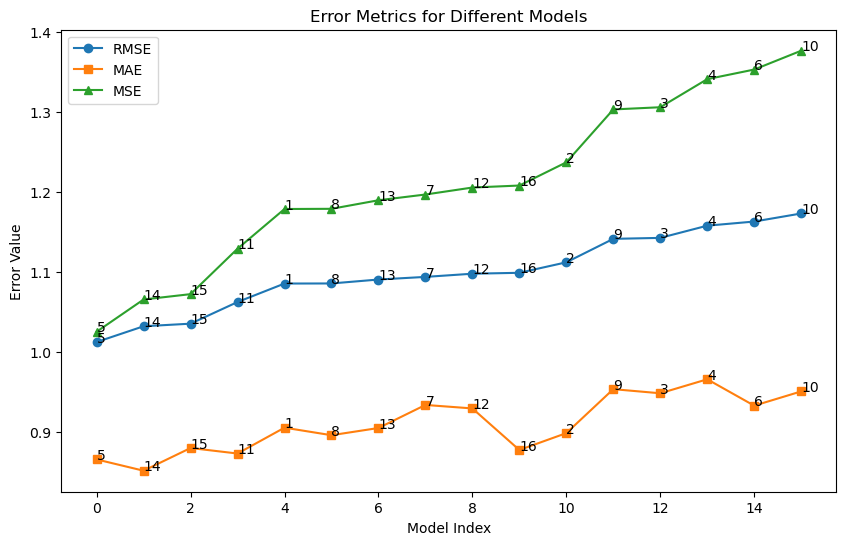

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

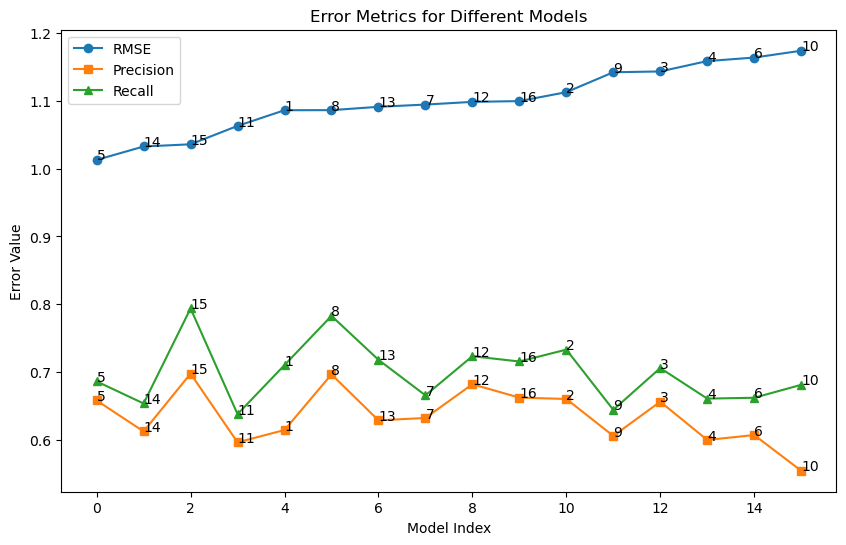

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

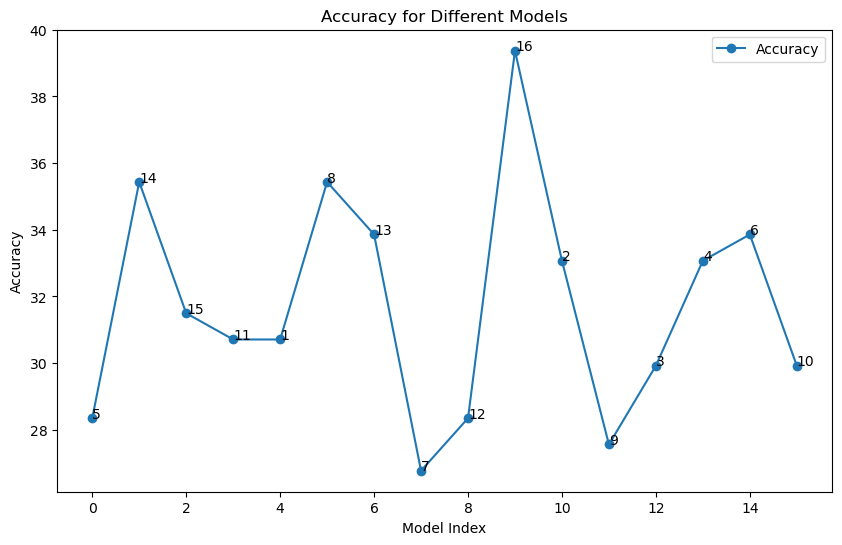

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Quintessence Montagny 1er Cru
2. Item ID: Mendoza Chardonnay
3. Item ID: Groot Constantia
4. Item ID: Yellow Label 
5. Item ID: Pinot gris
6. Item ID: Petit Chablis
7. Item ID: Valle de Casablanca Sauvignon
8. Item ID: Australia Shiraz


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 91cf68cc-9436-43e1-871d-33beef4d2337


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['406ed450-5225-41ac-a02f-3ac1d1a1179b',
 'a94874d2-6af9-4651-a1d3-036ed714f2cb',
 '875e7ce2-5a96-497c-9816-563713e93ca8',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 '2ae69fac-d491-412f-8164-ccaf59a230c2',
 'deb9001b-2e33-42ca-8953-35c11e0ed824',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 '25a04c51-5638-42f0-b2e7-ce49b1c280fc',
 'bc79b0e3-064d-4240-86de-e86499f577e8',
 '5ccd8030-047b-432c-a630-d784ab415756']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['Pinot Nero',
 'pelaverga',
 'Arneis',
 'Brunello di Montalcino',
 'Montefalco Rosso',
 'Ronco del Balbo Merlot',
 'Bolgheri+',
 'Rascal',
 'Chianti',
 'Tramonto d’oca']

In [28]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 13 with sim 1.000000000000000
And the baseline estimate is: 4.00071403576817

#####

Note: If the baseline is 3.6930693069306932 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Rouge,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",5,0,0.351485
1,5ccd8030-047b-432c-a630-d784ab415756,Il Castelliere Passito Bianco,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",40,1,0.351485
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Brunello di Montalcino,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",56,0,0.351485
3,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Inganno 572,5.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",30,0,1.351485
4,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Bollicina,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",1,3,2.000000
5,7ed7fb0c-884d-46bf-a14a-205474a0949d,Bardolino,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",0,1,2.000000
6,7cb9aba3-78f1-4ad5-97ca-8bcc29fb021a,Aragosta Rosé,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",2,1,0.351485
7,dcd16582-14d2-4e00-a024-9b5886d29b29,Los cardos Dulce. Edición especial 2021,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",5,1,0.351485
8,bc79b0e3-064d-4240-86de-e86499f577e8,"Guillot, Julien (Vignes du Maynes) 2018",4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",27,0,0.351485
9,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Baron amarillo rioja denomacion de origen cali...,4.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",26,0,0.351485


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
63,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,5.0,"{'actual_k': 9, 'was_impossible': False}",56,1,0.0
51,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cabernet Franc,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",30,2,0.0
21,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bolgheri+,2.0,2.0,"{'actual_k': 12, 'was_impossible': False}",56,2,0.0
64,bc79b0e3-064d-4240-86de-e86499f577e8,Dolcetto d'Alba Classici,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",27,1,0.0
72,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Amarone,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",3,1,0.0
74,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Langhe Nebbiolo,3.0,3.0,"{'actual_k': 12, 'was_impossible': False}",56,1,0.0
76,b61f83a4-48c5-49a5-aee5-72f7d5221b2a,Cabernet Sauvignon,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",2,5,0.0
79,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Cerasuolo di Vittoria,3.0,3.0,"{'actual_k': 12, 'was_impossible': False}",56,1,0.0
81,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Bordeaux,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",26,2,0.0
37,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Corvina,2.0,2.0,"{'actual_k': 12, 'was_impossible': False}",56,1,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
106,5ccd8030-047b-432c-a630-d784ab415756,La Moneta Gavi,2.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",40,1,1.648515
5,7ed7fb0c-884d-46bf-a14a-205474a0949d,Bardolino,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",0,1,2.000000
118,91cf68cc-9436-43e1-871d-33beef4d2337,Chardonnay,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",10,9,2.000000
67,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,2.000000,"{'actual_k': 0, 'was_impossible': False}",8,2,2.000000
4,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Bollicina,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",1,3,2.000000
103,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",27,0,2.648515
92,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.648515
109,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 6,1.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",27,0,2.648515
35,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",40,1,2.648515
114,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,1.0,3.648515,"{'was_impossible': True, 'reason': 'User and/o...",1,2,2.648515
